# Running analog Hamiltonian simulation with local simulator

It is advised to test and debug an analog Hamiltonian simulation (AHS) program on the local simulator before submitting it to the QPU. In this notebook, we introduce several features of the local simulator that will be useful to streamline this testing process.

To begin, we import the necessary packages.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from ahs_utils import show_register, show_global_drive, show_final_avg_density, get_drive, get_avg_density
from braket.devices import LocalSimulator

## 1D $Z_2$ phase 

In [this notebook](https://github.com/aws/amazon-braket-examples/blob/main/examples/analog_hamiltonian_simulation/02_Ordered_phases_in_Rydberg_systems.ipynb), we considered a chain of 9 atoms, and realized the 1D $Z_2$ phase via adiabatic evolution. Here we will consider a chain with 15 atoms with exactly the same driving field, which is expected to realize the similar $Z_2$ phase.

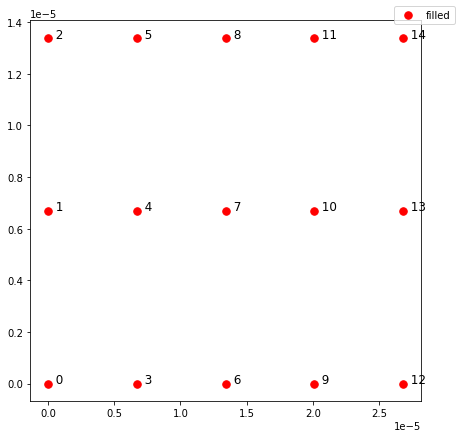

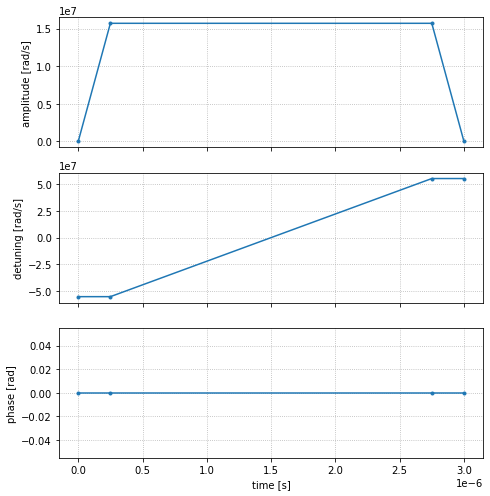

In [3]:
register = AtomArrangement()
separation = 6.7e-6  # in meters 

for k in range(5):
    for l in range(3):
        register.add((k * separation, l * separation))


time_points = [0, 2.5e-7, 2.75e-6, 3e-6]
amplitude_min = 0
amplitude_max = 1.57e7  # rad / s

detuning_min = -5.5e7  # rad / s
detuning_max = 5.5e7  # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)    
    
    
show_register(register)
show_global_drive(drive);

The AHS program can be constructed by assembling the atomic register with the driving field.

In [4]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

We can then run the program on the local simulator as usual.

In [5]:
device = LocalSimulator("braket_ahs")

<div class="alert alert-block alert-info">
<b>Note: </b> The following cell will take around 15-40 minutes to complete, depending on the host machine used.
</div>


In [6]:
start_time = time.time()
result_full = device.run(ahs_program, shots=1000).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 1012.0565650463104 seconds


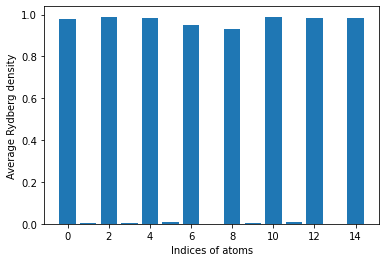

In [7]:
show_final_avg_density(result_full)

## Run AHS program in the blockade subspace

As we can see above, it takes a much longer time to finish the simulation because the *full* Hamiltonian is of size $2^{15}\times 2^{15}$. However, because of Rydberg blockade, we know that neighboring atoms are very unlikely to be excited to the Rydberg states simultaneously. Hence the *effective* Hamiltonian for the adiabatic evolution is much smaller then the full Hamiltonian of the system. We can take advantage of this fact by setting the parameter `blockade_radius` to the atomic separation to speed up the simulation.

In [8]:
start_time = time.time()
result_blockade = device.run(ahs_program, shots=1000, blockade_radius=separation).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 18.673676013946533 seconds


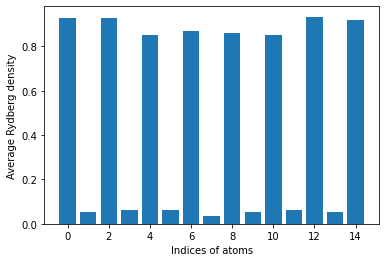

In [9]:
show_final_avg_density(result_blockade)

In order to quantify the difference in the final average Rydberg densities from the two simulations, we can calculate the root-mean-square difference (RMS) defined as 
\begin{align}
\text{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^N(\bar{n}_i^\text{full}-\bar{n}_i^\text{blockade})^2}.
\end{align}
Here $\bar{n}_i^\text{full}$ and $\bar{n}_i^\text{blockade}$ are the final Rydberg density at the $i$-th site for the simulation with full Hilbert space and truncated Hilbert space respectively.

In [10]:
n_full = get_avg_density(result_full)
n_blockade = get_avg_density(result_blockade)

RMS_blockade = np.sqrt(np.mean((np.array(n_full)-np.array(n_blockade))**2))
print(f"The RMS_blockade for the final Rydberg densities = {RMS_blockade}")

The RMS_blockade for the final Rydberg densities = 0.07260257112067954


Since the RMS is only around 7%, we are assured that the simulation with truncated Hilbert space give quantitatively the same results as the one with the full Hilbert space.

## Tuning other parameters in the local simulator

Another way to speed up the simulation is to adjust other parameters of the local simulator, such as `rtol`, which is the relative tolerance for solution. It is set to `1e-6` by default, but we can set it to `1e-2`, which tolerate a slightly larger error. We can also reset `order` to 2 for the solver. 

<div class="alert alert-block alert-info">
<b>Note: </b> The following cell will take around 10-30 minutes to complete, depending on the host machine used.
</div>


In [11]:
start_time = time.time()
result_reduced_nsteps = device.run(ahs_program, shots=1000, rtol=1e-2, order=2).result()
print(f"The elapsed time = {time.time()-start_time} seconds")

The elapsed time = 960.0890870094299 seconds


We can confirm that the simulation produces result that is close to our expectation. 

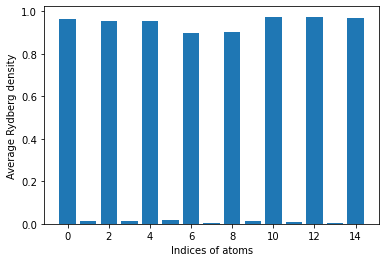

In [12]:
show_final_avg_density(result_reduced_nsteps)

In [13]:
n_reduced_nsteps = get_avg_density(result_reduced_nsteps)

RMS_reduced_nsteps = np.sqrt(np.mean((np.array(n_full)-np.array(n_reduced_nsteps))**2))
print(f"The RMS_reduced_nsteps for the final Rydberg densities = {RMS_reduced_nsteps}")

The RMS_reduced_nsteps for the final Rydberg densities = 0.02104914883473122


We see that although the runtime is reduced compared to the simulation with default parameters, it is still much longer than the simulation performed in the reduced Hilbert space. The reason is that the local simulator will need to construct the Hilbert space in which the simulation is performed, and this takes majority part of the runtime. 

We also note that when the dimension of the Hilbert space is larger than 1000, the AHS local simulator use `scipy.integrate.ode` as the backend solver and support the following arguments: <code>atol</code>, <code>rtol</code>, <code>solver_method</code>, <code>order</code>, <code>nsteps</code>, <code>first_step</code>, <code>max_step</code> and <code>min_step</code>. For more information, please refer to the following <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html">documentation page</a>.

Additionally, one could also tune the argument `steps` to adjust the number of time points for the simulation, which is set to `100` by default. 

In [14]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.00 USD
